In [2]:
#libreria para manejo de NDARRAY
import numpy as np;
import scipy as sp
#libreria para graficar
import matplotlib.pyplot as plt
#Lector de archivos csv
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym
import pandas as pd
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import pingouin as pg
from scipy.signal import welch as pwelch

In [6]:
ruta_carpeta = '../control'

# Obtener la lista de archivos en la carpeta
lista_archivos = os.listdir(ruta_carpeta)

# Crear una matriz vacía para almacenar los datos
datos_matriz = [] # num_columnas es el número de columnas en los datos

# Iterar a través de cada archivo y agregar los datos a la matriz
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_matriz.append(data)

ruta_carpeta = '../parkinson'
lista_archivos = os.listdir(ruta_carpeta)
datos_parkinson=[]
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_parkinson.append(data)
print("Todo cargado")

Todo cargado


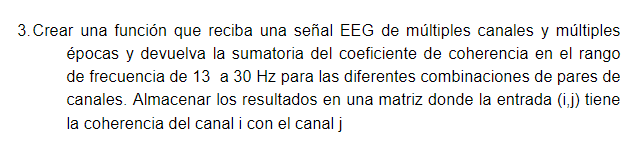

In [12]:
def deflrange(x,ini=13,end=30,fs=1000):
    N=len(x)
    f=np.linspace(0,fs,num=N)
    bf=np.where((f>=ini) &(f<=end))
    f=f[bf]
    x=x[bf]
    return f,x

In [1]:
def coherence_matrix(data, fs):
    n_channels, n_epochs, n_samples = data.shape
    
    # Definir los límites de frecuencia para calcular la coherencia
    fmin = 13
    fmax = 30
    
    # Calcular el índice de las frecuencias correspondientes
    freqs = np.fft.fftfreq(n_samples, 1/fs)
    idx_band = np.where((freqs >= fmin) & (freqs <= fmax))[0]
    
    # Inicializar la matriz de coherencia
    coh_matrix = np.zeros((n_channels, n_channels))
    
    # Calcular la coherencia para cada par de canales
    for i in range(n_channels):
        for j in range(n_channels):
            coh_sum = 0
            
            for k in range(n_epochs):
                x = data[i, k, :]
                y = data[j, k, :]
                
                X = np.fft.fft(x)
                Y = np.fft.fft(y)
                
                sxy = X[idx_band] * Y[idx_band].conjugate()
                sxx = X[idx_band] * X[idx_band].conjugate()
                syy = Y[idx_band] * Y[idx_band].conjugate()
                
                sxy = np.mean(sxy.real)
                sxx = np.mean(sxx.real)
                syy = np.mean(syy.real)
                
                cohxy = np.abs(sxy) / np.sqrt(sxx * syy)
                
                coh_sum += cohxy
            
            coh_matrix[i, j] = coh_sum / n_epochs
            coh_matrix[j, i] = coh_sum / n_epochs
            
    return coh_matrix

In [7]:
a=coherence_matrix(datos_matriz[0],1000)

In [9]:
df=pd.DataFrame(a) #El mejor machetazo de la hisotoria
df

,0,1,2,3,4,5,6,7
0,1.000000,0.741405,0.397710,0.343328,0.402899,0.316456,0.367784,0.429152
1,0.741405,1.000000,0.688243,0.404830,0.364306,0.361901,0.428859,0.491642
2,0.397710,0.688243,1.000000,0.663684,0.425973,0.426328,0.445878,0.443500
3,0.343328,0.404830,0.663684,1.000000,0.449995,0.467944,0.434403,0.411781
4,0.402899,0.364306,0.425973,0.449995,1.000000,0.382749,0.378748,0.361736
5,0.316456,0.361901,0.426328,0.467944,0.382749,1.000000,0.898557,0.649221
6,0.367784,0.428859,0.445878,0.434403,0.378748,0.898557,1.000000,0.838625
7,0.429152,0.491642,0.443500,0.411781,0.361736,0.649221,0.838625,1.000000


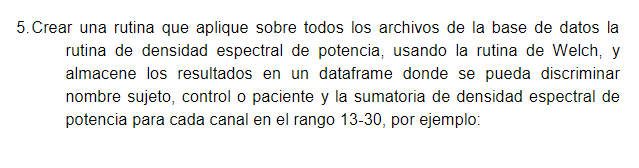

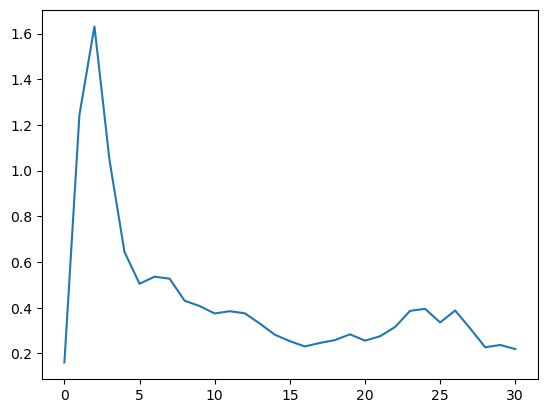

In [30]:
x=datos_matriz[0]
x=np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]),order='F')[0]
fs=1000
nperseg=2000
noverlap=0
f,Pxx=pwelch(x,fs,"hamming",nperseg=nperseg,noverlap=noverlap)
f,x=deflrange(Pxx,f)
plt.plot(f,x)


In [10]:
def PSD(data):
    fs=1000
    nperseg=2000
    noverlap=0
    f,Pxx=pwelch(data,fs,"hamming",nperseg=nperseg,noverlap=noverlap)
    f,x=deflrange(Pxx,f)
    return np.sum(x)


In [19]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
"""Se crea rutina con ciclos anidados para recorrer la matriz de pacientes y los canales de cada uno de estos"""

for i in r:
    promcanales=["Control"]
    x=datos_matriz[i]
    senal_continua = np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]),order='F')
    for canales in senal_continua:
        canal=PSD(canales)
        promcanales.append(canal)
    datosprompaciente.append(promcanales)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))

for i in r:
    promcanales=["Parkinson"]
    x=datos_parkinson[i]
    senal_continua = np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]),order='F')
    for canales in senal_continua:
        canal=PSD(canales)
        promcanales.append(canal)
    datosprompaciente_p.append(promcanales)

In [20]:
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2'] #Los nombres de las columnas

In [21]:
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
#Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente 
# (lista con primedio de cada canal) y el contador para identificar el paciente
for paciente in datosprompaciente: 
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
Sujeto,,,,,,,,,
1,Control,13.490920,13.921045,15.570281,12.427139,23.139985,17.712552,16.932344,17.236499
2,Control,12.154628,14.002824,16.571053,15.059030,12.213229,80.680560,57.342499,65.702461
3,Control,10.411981,15.630907,24.359392,12.062959,24.392745,12.314163,13.468292,15.961881
4,Control,25.888291,27.811328,31.180433,27.705947,25.687906,90.355121,93.708416,97.210364
5,Control,11.968519,13.175787,14.203722,14.666902,15.776888,41.688950,29.059793,33.418601
6,Control,8.618163,9.965919,11.538701,8.241247,9.615590,20.313454,16.592858,16.467388
7,Control,7.674582,7.576030,8.625929,7.231297,6.574051,17.352270,12.149756,22.292293
8,Control,23.949981,23.266005,13.948782,14.312607,20.895406,79.376321,46.511100,61.662243
9,Control,7.836586,8.053699,10.413469,9.757397,9.104441,40.419365,39.152962,42.976151


In [22]:
df.to_csv("Tabla.cvs",index=False)

In [156]:
df=pd.read_csv("Tabla.cvs")

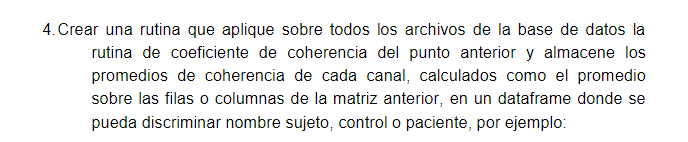

In [15]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
"""Se crea rutina con ciclos anidados para recorrer la matriz de pacientes y los canales de cada uno de estos"""

for i in r:
    promcanales="Control"
    x=coherence_matrix(datos_matriz[i],1000)
    x=x.mean(0).tolist()
    x.insert(0,promcanales)
    datosprompaciente.append(x)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))

for i in r:
    promcanales="Parkinson"
    x=coherence_matrix(datos_matriz[i],1000)
    x=x.mean(0).tolist()
    x.insert(0,promcanales)
    datosprompaciente_p.append(x)

In [16]:
names = ["Estado",'Coherencia_promedio_PSD_C3', 'Coherencia_promedio_PSD_C1', 'Coherencia_promedio_PSD_CZ', 'Coherencia_promedio_PSD_C2', 'Coherencia_promedio_PSD_C4', 'Coherencia_promedio_PSD_O1', 'Coherencia_promedio_PSD_OZ', 'Coherencia_promedio_PSD_O2'] #Los nombres de las columnas

In [17]:
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
#Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente 
# (lista con primedio de cada canal) y el contador para identificar el paciente
for paciente in datosprompaciente: 
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,Coherencia_promedio_PSD_C3,Coherencia_promedio_PSD_C1,Coherencia_promedio_PSD_CZ,Coherencia_promedio_PSD_C2,Coherencia_promedio_PSD_C4,Coherencia_promedio_PSD_O1,Coherencia_promedio_PSD_OZ,Coherencia_promedio_PSD_O2
Sujeto,,,,,,,,,
1,Control,0.499842,0.560148,0.561414,0.521996,0.470801,0.562895,0.599107,0.578207
2,Control,0.597671,0.687340,0.698110,0.678877,0.581131,0.678436,0.728362,0.693179
3,Control,0.613232,0.625712,0.709685,0.699314,0.707645,0.642616,0.666994,0.650577
4,Control,0.567778,0.658387,0.679986,0.642864,0.523429,0.639938,0.668105,0.648874
5,Control,0.561897,0.605891,0.585076,0.581729,0.522060,0.566426,0.624889,0.594398
6,Control,0.522370,0.606228,0.623980,0.600540,0.505646,0.590771,0.621438,0.609594
7,Control,0.539077,0.679871,0.700044,0.686629,0.564365,0.705911,0.645171,0.685401
8,Control,0.541632,0.568163,0.572778,0.569539,0.537346,0.540866,0.591336,0.525030
9,Control,0.561255,0.695035,0.723360,0.695216,0.591959,0.665814,0.699894,0.647769


In [18]:
df.to_csv("Tabla_coherencia.cvs",index=False)

In [ ]:
df2=pd.read_csv("Tabla.cvs")